In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score

from datetime import datetime
from datetime import timedelta

In [0]:
import pandas as pd
import numpy as np
import matplotlib as plt
master_database=pd.read_csv("train_spray_weather_v1.csv",float_precision='round_trip')
master_database['yr_mo']=master_database['year'].astype(str) + '-' + master_database['month'].astype(str)

In [0]:
model_master_database=master_database
model_master_database['min_spary_dist']=model_master_database.iloc[:,15:25].min(axis=1)
model_master_database['min_spary_time']=model_master_database.iloc[:,25:35].min(axis=1)

In [0]:
model_master_database_2=pd.concat([model_master_database.iloc[:,7:11],
           model_master_database.iloc[:,13],model_master_database.iloc[:,15:35],
           model_master_database.iloc[:,40:48],model_master_database.iloc[:,49:76]],axis=1)

In [0]:
from datetime import datetime
model_master_database_2['Sunrise_Station'] = pd.to_datetime(model_master_database_2['Sunrise_Station'], 
                                                            format='%H:%M:%S')
model_master_database_2['Sunset_Station'] = pd.to_datetime(model_master_database_2['Sunset_Station'], 
                                                            format='%H:%M:%S')
model_master_database_2['length_of_day']=(model_master_database_2['Sunset_Station'] - model_master_database_2['Sunrise_Station']).dt.total_seconds()

model_master_database_2['length_of_day']=model_master_database_2['length_of_day'].astype(int)
model_master_database_2=model_master_database_2.drop(['Sunrise_Station', 'Sunset_Station'], axis=1) 

In [0]:
columns_high_corr = abs(model_master_database_2.corr()["WnvPresent"]).sort_values(ascending=False).round(3).index[2:12]

In [0]:
training_features = model_master_database_2[columns_high_corr]
training_target = model_master_database_2["WnvPresent"]
training_features.shape

(8610, 10)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(training_features, training_target,test_size = .2,
                                                    random_state=11, shuffle = True)

In [0]:
model_master_database_2["WnvPresent"].value_counts()

0    8153
1     457
Name: WnvPresent, dtype: int64

In [0]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_mod, y_train_mod = sm.fit_sample(x_train, y_train)
x_test_mod, y_test_mod = sm.fit_sample(x_test, y_test)

In [0]:
x_train_mod_pd = pd.DataFrame(x_train_mod)
x_train_mod_pd.columns = x_train.columns
y_train_mod_pd = pd.Series(y_train_mod)

In [0]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()

print("Cross validation on over sampled train data:\n",cross_val_score(lg, x_train_mod,y_train_mod,n_jobs=-1, cv = 10).round(3),"\n")

print("Cross validation on test data: \n", cross_val_score(lg, x_test,y_test,n_jobs=-1, cv = 10).round(3), "\n")

Cross validation on over sampled train data:
 [0.639 0.638 0.655 0.623 0.641 0.642 0.644 0.651 0.658 0.643] 

Cross validation on test data: 
 [0.948 0.948 0.948 0.953 0.953 0.953 0.953 0.953 0.953 0.953] 



**Logistic Regression**

In [0]:
lg.fit(x_train_mod, y_train_mod)
predicted = lg.predict(x_train_mod)
print("R2 score on train dataset: ", lg.score(x_train_mod, y_train_mod).round(3))
print("ROC score on train dataset: ", roc_auc_score(y_train_mod, predicted).round(3))

R2 score on train dataset:  0.644
ROC score on train dataset:  0.644


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
print("R2 score on test dataset: ", lg.score(x_test, y_test).round(3))
predicted = lg.predict(x_test)
print("ROC score on test dataset: ",roc_auc_score(y_test, predicted).round(3))

R2 score on test dataset:  0.596
ROC score on test dataset:  0.656


In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted)

array([[966, 673],
       [ 23,  60]])

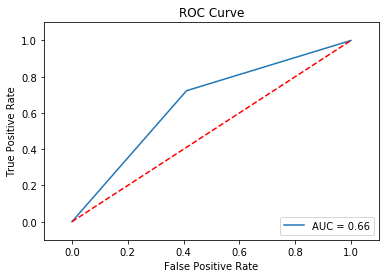

In [0]:
from sklearn import metrics
# take the second column because the classifier outputs scores for
# the 0 class as well
preds = predicted

# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))


plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

**Gradient Boost classifier**

In [0]:
gbc = GradientBoostingClassifier()
print("Cross validation on train dataset: \n", cross_val_score(gbc, x_train_mod,y_train_mod, n_jobs=-1, cv = 10).round(3), "\n")
print("Cross validation on test dataset: \n", cross_val_score(gbc, x_test,y_test, n_jobs=-1, cv = 10).round(3), "\n")

Cross validation on train dataset: 
 [0.79  0.823 0.847 0.831 0.839 0.845 0.855 0.839 0.843 0.856] 

Cross validation on test dataset: 
 [0.936 0.936 0.942 0.948 0.948 0.936 0.953 0.953 0.953 0.953] 



In [0]:
gbc.fit(x_train_mod, y_train_mod)
predicted = gbc.predict(x_train_mod)
print("R2 score on train dataset: ", gbc.score(x_train_mod, y_train_mod).round(3))
print("ROC score on train dataset: ", roc_auc_score(y_train_mod ,predicted).round(3))

R2 score on train dataset:  0.844
ROC score on train dataset:  0.844


In [0]:
predicted = gbc.predict(x_test)
print("R2 score on test dataset: ", gbc.score(x_test, y_test).round(3))
print("ROC score on test dataset: ", roc_auc_score(y_test, predicted).round(3))

R2 score on test dataset:  0.77
ROC score on test dataset:  0.708


In [0]:
score_function = make_scorer(roc_auc_score)
params_gbc = {
    "gbc__learning_rate"  : [1],
    "gbc__n_estimators"     : [10, 100, 300],
    "gbc__max_depth"  : [3, 10],
    "gbc__random_state"    : [42]
             }
steps_gbc = [('gbc', GradientBoostingClassifier())]
pipe_gbc = Pipeline(steps = steps_gbc)
gs_gbc = GridSearchCV(pipe_gbc, param_grid = params_gbc , scoring = score_function, verbose=1)

In [0]:
gs_gbc.fit(x_train_mod, y_train_mod)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   45.7s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('gbc',
                                        GradientBoostingClassifier(criterion='friedman_mse',
                                                                   init=None,
                                                                   learning_rate=0.1,
                                                                   loss='deviance',
                                                                   max_depth=3,
                                                                   max_features=None,
                                                                   max_leaf_nodes=None,
                                                                   min_impurity_decrease=0.0,
                                                                   min_impurity_split=None,
                                                                   min

In [0]:
gs_gbc.best_params_

{'gbc__learning_rate': 1,
 'gbc__max_depth': 10,
 'gbc__n_estimators': 300,
 'gbc__random_state': 42}

In [0]:
gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=42, max_depth=10)
gbc.fit(x_train_mod, y_train_mod)
predicted = gbc.predict(x_train_mod)
print("R2 score on train dataset: ", gbc.score(x_train_mod, y_train_mod).round(3))
print("ROC score on train dataset: ", roc_auc_score(y_train_mod ,predicted).round(3))

R2 score on train dataset:  0.978
ROC score on train dataset:  0.978


In [0]:

predicted = gbc.predict(x_test)
print("R2 score on test dataset: ", gbc.score(x_test, y_test).round(3))
print("ROC score on test dataset: ", roc_auc_score(y_test, predicted).round(3))

R2 score on test dataset:  0.913
ROC score on test dataset:  0.594


In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted)

array([[1552,   87],
       [  63,   20]])

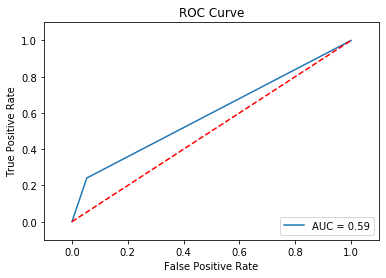

In [0]:
from sklearn import metrics
# take the second column because the classifier outputs scores for
# the 0 class as well
preds = predicted

# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))


plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

**Random Forest Classifier**

In [0]:
rfc = RandomForestClassifier()
print("Cross validation score on train dataset: ", cross_val_score(rfc, x_train_mod,y_train_mod, n_jobs=-1).round(3), "\n")
print("Cross validation score on test dataset: ", cross_val_score(rfc, x_test,y_test, n_jobs=-1).round(3), "\n")

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Cross validation score on train dataset:  [0.886 0.923 0.916] 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Cross validation score on test dataset:  [0.939 0.941 0.937] 



In [0]:

rfc.fit(x_train_mod, y_train_mod)
print("R2 score on train dataset: ", rfc.score(x_train_mod, y_train_mod).round(3))
predicted = rfc.predict(x_train)
print("ROC score on train dataset: ", roc_auc_score(y_train, predicted).round(3))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R2 score on train dataset:  0.978
ROC score on train dataset:  0.805


In [0]:
print("R2 score on test dataset: ", rfc.score(x_test, y_test).round(3))
predicted = rfc.predict(x_test)
print("ROC score on test dataset: ", roc_auc_score(y_test, predicted).round(3))

R2 score on test dataset:  0.902
ROC score on test dataset:  0.594


In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted)

array([[1532,  107],
       [  62,   21]])

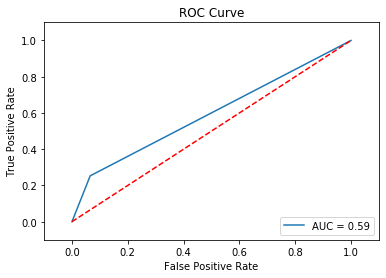

In [0]:
from sklearn import metrics
# take the second column because the classifier outputs scores for
# the 0 class as well
preds = predicted

# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))


plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

**XGBOOST model**

In [0]:
xgb = XGBClassifier(n_estimators = 500)
xgb.fit(x_train_mod_pd, y_train_mod_pd)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
print("R2 score on train dataset: ", xgb.score(x_train_mod_pd, y_train_mod_pd).round(3))
predicted = xgb.predict(x_train_mod_pd)
print("ROC score on train dataset: ", roc_auc_score(y_train_mod_pd, predicted).round(3))

R2 score on train dataset:  0.931
ROC score on train dataset:  0.931


In [0]:

print("R2 score on test dataset: ", xgb.score(x_test, y_test).round(3))
predicted = xgb.predict(x_test)
print("ROC score on test dataset: ", roc_auc_score(y_test, predicted).round(3))

R2 score on test dataset:  0.878
ROC score on test dataset:  0.65


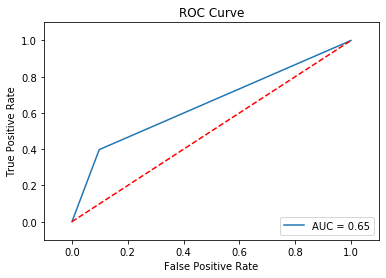

In [0]:
from sklearn import metrics
# take the second column because the classifier outputs scores for
# the 0 class as well
preds = predicted

# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

auc_score = metrics.auc(fpr, tpr)

# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))


plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted)

array([[1479,  160],
       [  50,   33]])